In [14]:
import pandas as pd
import networkx as nx

# -------------------------------
# 1. Load the FAOSTAT CSV file
# -------------------------------
FILE = "C:\\Users\\leonc\\cbd-notebooks\\Trade_DetailedTradeMatrix_E_All_Data.csv"

df = pd.read_csv(FILE)

print("Columns in file:")
print(df.columns.tolist())

# -------------------------------------------
# 2. Reshape the wide-year format to long
# -------------------------------------------
# Select only year columns (Y1986, Y1987, ...), ignore flags (Y1986F, etc.)
year_cols = [c for c in df.columns if c.startswith("Y") and not c.endswith("F")]

df_long = df.melt(
    id_vars=[
        "Reporter Countries",
        "Partner Countries",
        "Item",
        "Element",
        "Unit"
    ],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# Remove "Y" prefix (convert "Y2010" → 2010)
df_long["Year"] = df_long["Year"].str[1:].astype(int)

# Drop rows with missing values
df_long = df_long.dropna(subset=["Value"])

# ---------------------------------------------------------
# 3. Filter for rice products (edit this list as needed)
# ---------------------------------------------------------
rice_items = [
    "Rice, paddy (rice milled equivalent)"
]

df_rice = df_long[df_long["Item"].isin(rice_items)]

# ---------------------------------------------------------
# 4. Filter for export quantity (most useful for networks)
# ---------------------------------------------------------
df_rice_exports = df_rice[df_rice["Element"].str.contains("Export quantity")]

print("\nSample filtered rows:")
print(df_rice_exports.head())

# ---------------------------------------------------------
# 5. Build edge list for network
# ---------------------------------------------------------
edges = df_rice_exports.rename(columns={
    "Reporter Countries": "source",
    "Partner Countries": "target"
})[["source", "target", "Year", "Value"]]

print("\nEdge list sample:")
print(edges.head())

# ---------------------------------------------------------
# 6. Build the network graph (directed weighted)
# ---------------------------------------------------------
G = nx.from_pandas_edgelist(
    edges,
    source="source",
    target="target",
    edge_attr=["Value", "Year"],
    create_using=nx.DiGraph()
)

print("\nGraph stats:")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# ---------------------------------------------------------
# 7. Save edge list for visualization in Gephi
# ---------------------------------------------------------
edges.to_csv("rice_trade_edges_gephi.csv", index=False)
print("\nSaved cleaned edge list: rice_trade_edges_gephi.csv")

C:\Users\leonc\AppData\Local\Temp\ipykernel_16352\1426343609.py:9: DtypeWarning: Columns (13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE)


Columns in file:
['Reporter Country Code', 'Reporter Country Code (M49)', 'Reporter Countries', 'Partner Country Code', 'Partner Country Code (M49)', 'Partner Countries', 'Item Code', 'Item Code (CPC)', 'Item', 'Element Code', 'Element', 'Unit', 'Y1986', 'Y1986F', 'Y1987', 'Y1987F', 'Y1988', 'Y1988F', 'Y1989', 'Y1989F', 'Y1990', 'Y1990F', 'Y1991', 'Y1991F', 'Y1992', 'Y1992F', 'Y1993', 'Y1993F', 'Y1994', 'Y1994F', 'Y1995', 'Y1995F', 'Y1996', 'Y1996F', 'Y1997', 'Y1997F', 'Y1998', 'Y1998F', 'Y1999', 'Y1999F', 'Y2000', 'Y2000F', 'Y2001', 'Y2001F', 'Y2002', 'Y2002F', 'Y2003', 'Y2003F', 'Y2004', 'Y2004F', 'Y2005', 'Y2005F', 'Y2006', 'Y2006F', 'Y2007', 'Y2007F', 'Y2008', 'Y2008F', 'Y2009', 'Y2009F', 'Y2010', 'Y2010F', 'Y2011', 'Y2011F', 'Y2012', 'Y2012F', 'Y2013', 'Y2013F', 'Y2014', 'Y2014F', 'Y2015', 'Y2015F', 'Y2016', 'Y2016F', 'Y2017', 'Y2017F', 'Y2018', 'Y2018F', 'Y2019', 'Y2019F', 'Y2020', 'Y2020F', 'Y2021', 'Y2021F', 'Y2022', 'Y2022F', 'Y2023', 'Y2023F']

Sample filtered rows:
      Rep

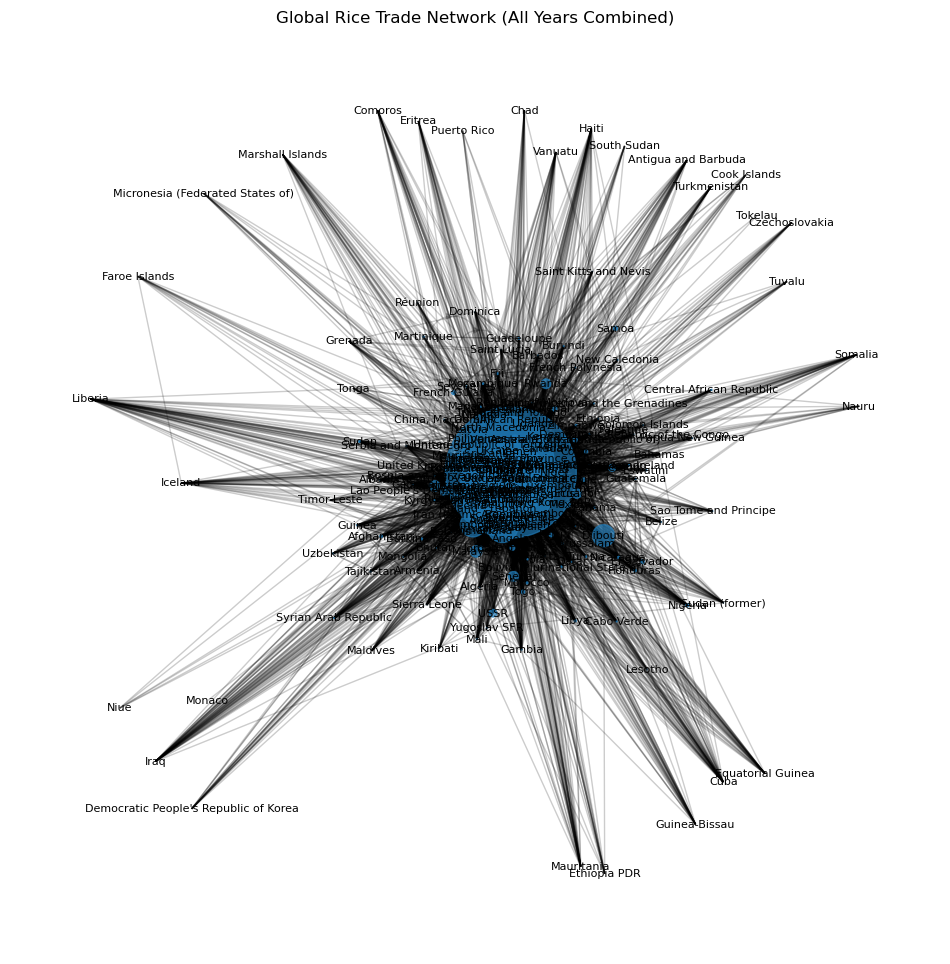

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph
G = nx.from_pandas_edgelist(
    edges,
    source="source",
    target="target",
    edge_attr=["Value", "Year"],
    create_using=nx.DiGraph()
)

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Node size = export volume (out-strength)
export_strength = dict(G.out_degree(weight="Value"))
sizes = [export_strength.get(n, 1)*0.0005 for n in G.nodes()]  # scale down

nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2, arrows=False)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Global Rice Trade Network (All Years Combined)")
plt.axis("off")
plt.show()


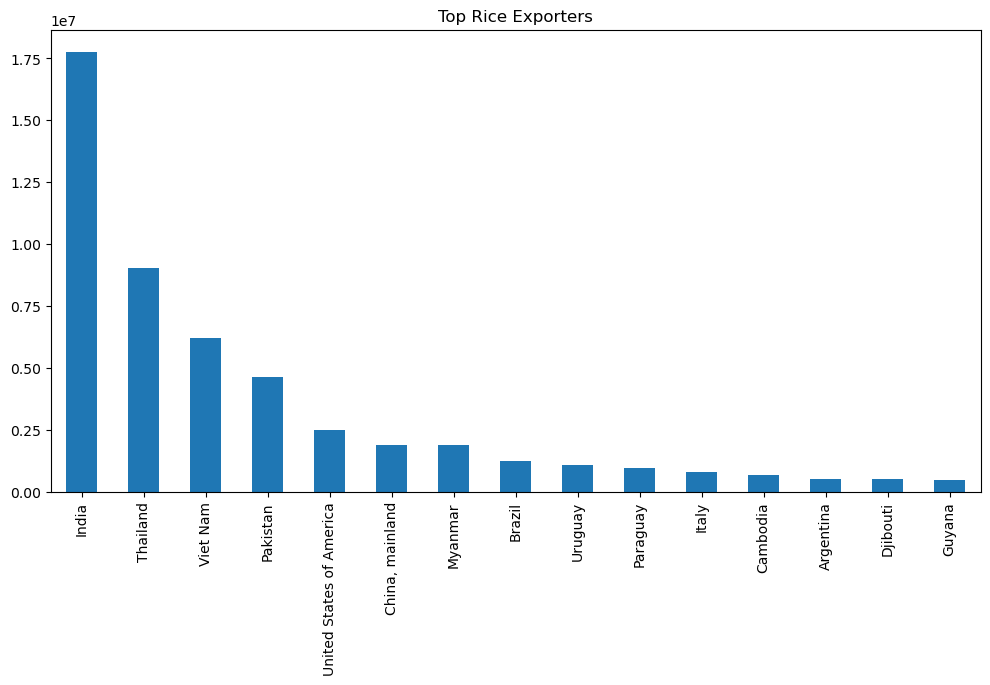

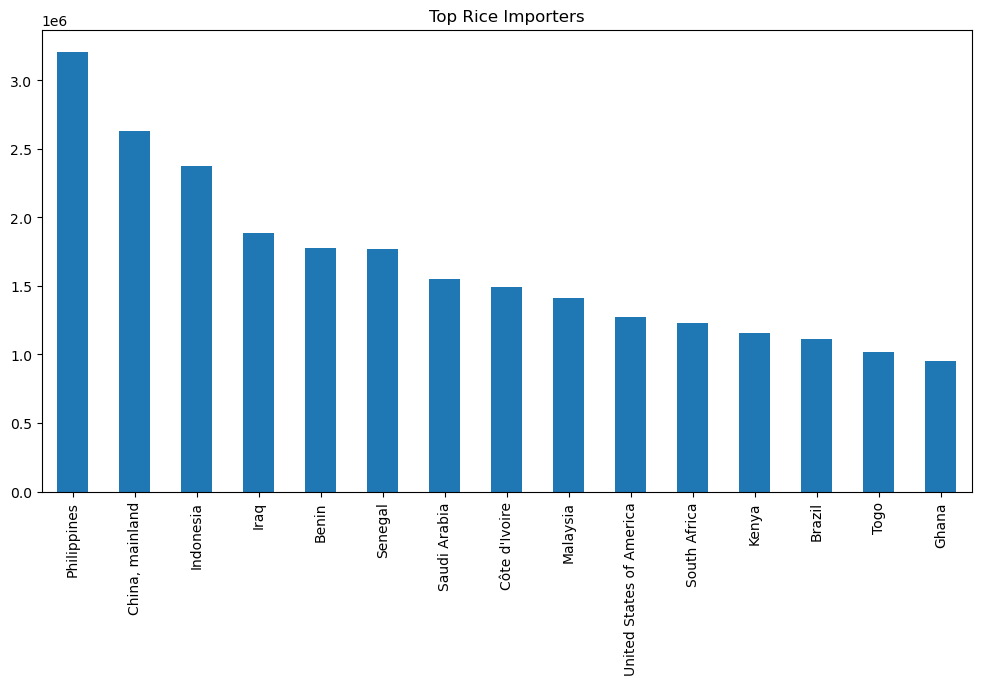

In [ ]:
import pandas as pd
  
# Out-strength = exports
export_strength = pd.Series(dict(G.out_degree(weight="Value"))).sort_values(ascending=False)
import_strength = pd.Series(dict(G.in_degree(weight="Value"))).sort_values(ascending=False)

export_strength.head(15).plot(kind="bar", figsize=(12,6), title="Top Rice Exporters")
plt.show()

import_strength.head(15).plot(kind="bar", figsize=(12,6), title="Top Rice Importers")
plt.show()


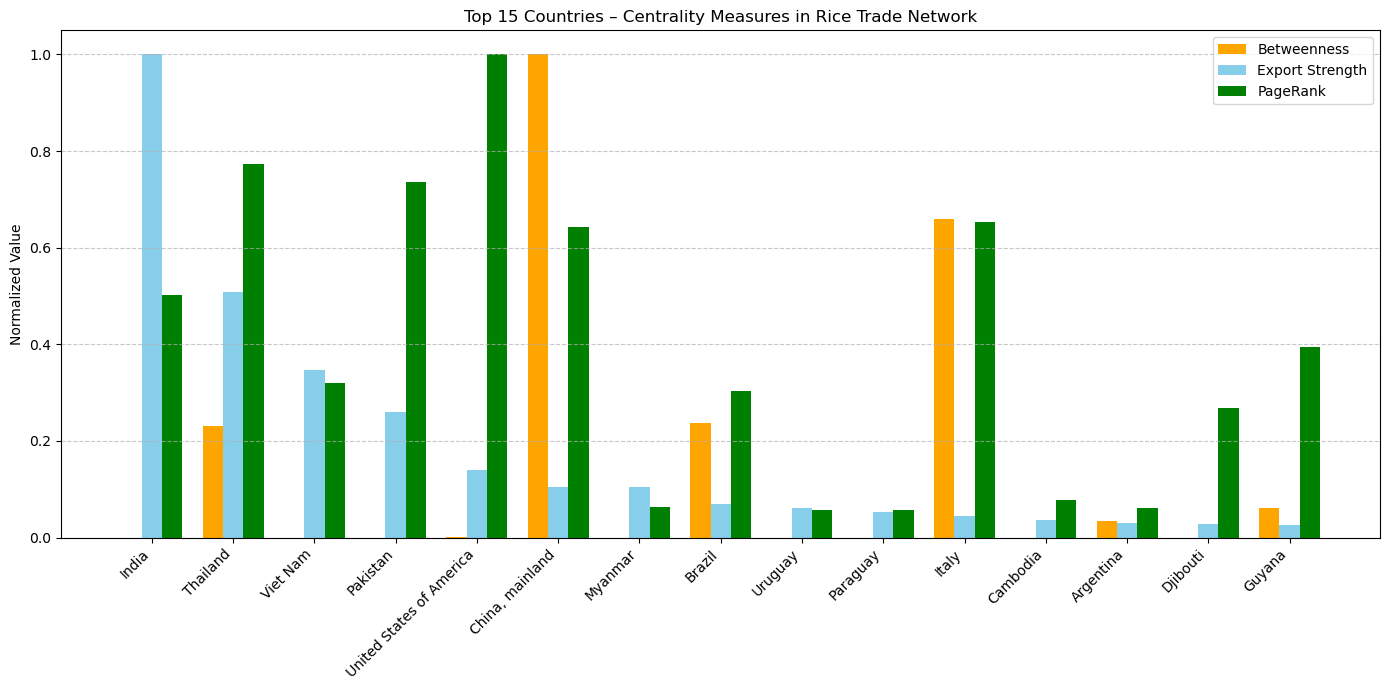

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Compute centrality measures ---
bet = nx.betweenness_centrality(G, weight="Value", normalized=True)
out_deg = dict(G.out_degree(weight="Value"))  # export strength
pr = nx.pagerank(G, weight="Value")

# --- 2. Create DataFrame ---
df_centrality = pd.DataFrame({
    "Betweenness": pd.Series(bet),
    "ExportStrength": pd.Series(out_deg),
    "PageRank": pd.Series(pr)
})

# --- 3. Select top countries by ExportStrength (or any measure) ---
top_n = 15
top_countries = df_centrality["ExportStrength"].sort_values(ascending=False).head(top_n).index
df_top = df_centrality.loc[top_countries]

# --- 4. Normalize values for plotting (optional, to compare scales) ---
df_plot = df_top / df_top.max()

# --- 5. Plot grouped bar chart ---
x = np.arange(len(df_plot))  # country positions
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(x - width, df_plot["Betweenness"], width, label='Betweenness', color='orange')
ax.bar(x, df_plot["ExportStrength"], width, label='Export Strength', color='skyblue')
ax.bar(x + width, df_plot["PageRank"], width, label='PageRank', color='green')

ax.set_xticks(x)
ax.set_xticklabels(df_plot.index, rotation=45, ha='right')
ax.set_ylabel("Normalized Value")
ax.set_title(f"Top {top_n} Countries – Centrality Measures in Rice Trade Network")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
